# Model usage

In [1]:
import ultralytics

In [2]:
ultralytics.checks()

Ultralytics YOLOv8.0.51 🚀 Python-3.10.6 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1080, 8111MiB)
Setup complete ✅ (8 CPUs, 31.3 GB RAM, 36.1/217.5 GB disk)


## Training

In [3]:
model = ultralytics.YOLO('models/yolov8s-blood-cell-detection.pt')

In [4]:
# yolo train model="models/yolov8s-blood-cell-detection.pt" data="data/agar/agar.yaml" epochs=50 imgsz=480 batch=8
model.train(data='data/agar/agar.yaml', imgsz=480, batch=8, epochs=3)

Ultralytics YOLOv8.0.51 🚀 Python-3.10.6 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1080, 8111MiB)
yolo/engine/trainer: task=detect, mode=train, model=models/yolov8s-blood-cell-detection.pt, data=data/agar/agar.yaml, epochs=3, patience=50, batch=8, imgsz=480, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False,

## Inference

In [3]:
model = ultralytics.YOLO('models/yolov8s-agar-s480-b10-e50.pt')

In [4]:
results = model.predict('data/creighton/IM10CN-R2A_edit.jpeg')


image 1/1 /mnt/d/projects/colony/data/creighton/IM10CN-R2A_edit.jpeg: 480x480 3 unknowns, 14 b_subtiliss, 30 s_aureuss, 5 e_colis, 7.2ms
Speed: 0.3ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 480)


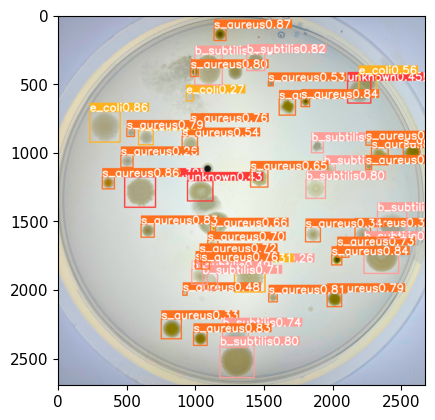

In [5]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt

img = cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

In [ ]:
%matplotlib inline

import json
import os
import pathlib

import numpy as np

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches

# Setup the location for the AGAR dataset.
DATA_PATH = 'data/agar/dataset/'


In [ ]:
# Determine unique labels from dataset.
label_set = set([])

for c, file_path in enumerate(pathlib.Path(DATA_PATH).glob('*.json')):
    if c % 1000 == 0:
        print(f'Files opened: {c}')
    with open(file_path, 'r') as f:
        json_dict = json.loads(f.read())
        label_set.update(json_dict['classes'])

with open(os.path.join(DATA_PATH, '../labels.txt')) as f:
    for c, label in enumerate(label_set):
        f.write(f'{c+1}:{label}\n')

In [ ]:
# Read the class labels back from disk.

class_labels = {}
with open(os.path.join(DATA_PATH, '../labels.txt')) as f:
    class_string = f.read()
    for class_tuple in class_string.split('\n'):
        if class_tuple:
            class_id, class_name = class_tuple.split(':')
            class_labels[class_name] =  int(class_id)

In [ ]:
# Convert the JSON labels into TXT equivalent files.

# Expected format for the label files is image000.txt with rows of:
# class_number box1_x1_ratio box1_y1_ratio box1_width_ratio box1_height_ratio
# The json records (x,y) as the ll_corner and txt encodes it as center.
def convert_json_to_txt_label(label_dict, image_width, image_height, class_dict, default_class_id=0):
    class_id = class_dict.get(label_dict['class']) or default_class_id
    return [class_id, 
            (label_dict['x'] + 0.5 * label_dict['width']) / image_width,
            (label_dict['y'] + 0.5 * label_dict['height']) / image_height,
            label_dict['width'] / image_width,
            label_dict['height'] / image_height,
            ]

for c in range(1,18000+1):
    if c % 1000 == 0:
        print(f'Processed {c}')
    try:
        im = Image.open(os.path.join(DATA_PATH, f'{c}.jpg'))
        with open(os.path.join(DATA_PATH, f'{c}.json'), 'r') as f:
            json_dict = json.loads(f.read())
        with open(os.path.join(DATA_PATH, f'{c}.txt'), 'w') as f:
            if 'labels' in json_dict:
                for class_bbox in json_dict['labels']:
                    id, x, y, w, h = convert_json_to_txt_label(class_bbox, im.width, im.height, class_labels)
                    f.write(f'{id:d} {x} {y} {w} {h}\n')
    except Exception as err:
        print(f'Image {c} failed.\nERROR= {err=}\nTYPE= {type(err)=}')

In [ ]:
index = 4001
im = Image.open(os.path.join(DATA_PATH, f'{index}.jpg'))
with open(os.path.join(DATA_PATH, f'{index}.json'), 'r') as f:
    json_dict = json.loads(f.read())
with open(os.path.join(DATA_PATH, f'{index}.txt'), 'r') as f:
    bbox_raw = [[float(x) for x in line.split(' ') if x] for line in f.read().split('\n') if line]



In [ ]:
# Create figure and axes for the original JSON data.
fig, ax = plt.subplots()
ax.imshow(im)
ax.grid(visible=False)
for bbox in json_dict['labels']:
    # Create a Rectangle patch
    rect = patches.Rectangle((bbox['x'], bbox['y']), bbox['width'], bbox['height'], linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()

# Create figure and axes for the new TXT data.
fig, ax = plt.subplots()
ax.imshow(im)
ax.grid(visible=False)
for bbox in bbox_raw:
    x = im.width * bbox[1]
    y = im.height * bbox[2]
    w = im.width * bbox[3]
    h = im.height * bbox[4]
    rect = patches.Rectangle((x-0.5*w, y-0.5*h), w, h, linewidth=1, edgecolor='b', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()

In [ ]:
label_file = '/media/bingjeff/8404A1F604A1EB7E/Users/bingj/Downloads/coco8/coco8/labels/train/000000000009.txt'
image_file = '/media/bingjeff/8404A1F604A1EB7E/Users/bingj/Downloads/coco8/coco8/images/train/000000000009.jpg'
im = Image.open(image_file)

with open(label_file) as f:
    bbox_raw = [[float(x) for x in line.split(' ') if x] for line in f.read().split('\n') if line]


# bowl    |45 0.479492 0.688771 0.955609 0.5955
# bowl    |45 0.736516 0.247188 0.498875 0.476417
# broccoli|50 0.637063 0.732938 0.494125 0.510583
# bowl    |45 0.339438 0.418896 0.678875 0.7815
# orange  |49 0.646836 0.132552 0.118047 0.0969375
# orange  |49 0.773148 0.129802 0.0907344 0.0972292
# orange  |49 0.668297 0.226906 0.131281 0.146896
# orange  |49 0.642859 0.0792187 0.148063 0.148062

# Create figure and axes for the new TXT data.
fig, ax = plt.subplots()
ax.imshow(im)
ax.grid(visible=False)
for bbox in bbox_raw:
    x = im.width * bbox[1]
    y = im.height * bbox[2]
    w = im.width * bbox[3]
    h = im.height * bbox[4]
    rect = patches.Rectangle((x-0.5*w, y-0.5*h), w, h, linewidth=1, edgecolor='b', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()

In [ ]:
bbox_raw[0]